<a href="https://colab.research.google.com/github/aarupach/Aaru/blob/main/Supervised_Learning_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

In [9]:
print("="*80)
print("TASK 3: SUPERVISED LEARNING ON TITANIC DATASET")
print("="*80)

TASK 3: SUPERVISED LEARNING ON TITANIC DATASET


In [10]:
print("\nSTEP 1: DATA PREPROCESSING")
print("-"*80)


STEP 1: DATA PREPROCESSING
--------------------------------------------------------------------------------


In [11]:
# Load dataset
print("\nLoading dataset...")
df = sns.load_dataset('titanic')
print(f"Dataset loaded: {df.shape}")


Loading dataset...
Dataset loaded: (891, 15)


In [12]:
# Data cleaning
df_clean = df.copy()

In [13]:
# Drop deck column
if 'deck' in df_clean.columns:
    df_clean = df_clean.drop('deck', axis=1)

In [14]:
# Fill missing age
df_clean['age'] = df_clean.groupby('pclass')['age'].transform(lambda x: x.fillna(x.median()))

In [15]:
# Fill missing embarked
if df_clean['embarked'].isnull().sum() > 0:
    df_clean['embarked'] = df_clean['embarked'].fillna(df_clean['embarked'].mode()[0])

In [16]:
# Fill embark_town if exists
if 'embark_town' in df_clean.columns:
    if df_clean['embark_town'].isnull().sum() > 0:
        df_clean['embark_town'] = df_clean['embark_town'].fillna(df_clean['embark_town'].mode()[0])

In [17]:
# Drop remaining nulls
df_clean = df_clean.dropna()

print(f"After cleaning: {df_clean.shape}")

After cleaning: (891, 14)


In [19]:
# Feature engineering
print("\nCreating new features...")
df_clean['family_size'] = df_clean['sibsp'] + df_clean['parch'] + 1
df_clean['is_alone'] = (df_clean['family_size'] == 1).astype(int)
df_clean['fare_per_person'] = df_clean['fare'] / df_clean['family_size']


Creating new features...


In [24]:
# Extract title
# df_clean['title'] = df_clean['name'].str.extract(' ([A-Za-z]+)\.', expand=False)
# title_map = {'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master'}
# df_clean['title'] = df_clean['title'].map(title_map).fillna('Other')

print("Features created: family_size, is_alone, fare_per_person")

Features created: family_size, is_alone, fare_per_person


In [28]:
# Encoding
print("\nEncoding categorical variables...")
df_encoded = df_clean.copy()
df_encoded['sex'] = df_encoded['sex'].map({'male': 1, 'female': 0})
# Removed 'title' from columns to encode as it was not created
df_encoded = pd.get_dummies(df_encoded, columns=['embarked'], drop_first=True)


Encoding categorical variables...


In [32]:
# Select features
feature_cols = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
                'family_size', 'is_alone', 'fare_per_person']

In [33]:
# Add dummy columns
for col in df_encoded.columns:
    if col.startswith('embarked_') or col.startswith('title_'):
        feature_cols.append(col)

X = df_encoded[feature_cols]
y = df_encoded['survived']

print(f"Features selected: {len(feature_cols)}")
print(f"X shape: {X.shape}, y shape: {y.shape}")

Features selected: 11
X shape: (891, 11), y shape: (891,)


In [34]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nTrain: {X_train.shape}, Test: {X_test.shape}")



Train: (712, 11), Test: (179, 11)


In [35]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Features scaled")

Features scaled


In [36]:
print("\n" + "="*80)
print("STEP 2: LOGISTIC REGRESSION")
print("-"*80)

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

lr_train_pred = lr_model.predict(X_train_scaled)
lr_test_pred = lr_model.predict(X_test_scaled)
lr_test_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

lr_train_acc = accuracy_score(y_train, lr_train_pred)
lr_test_acc = accuracy_score(y_test, lr_test_pred)
lr_roc_auc = roc_auc_score(y_test, lr_test_proba)

print(f"\nTrain Accuracy: {lr_train_acc:.4f}")
print(f"Test Accuracy: {lr_test_acc:.4f}")
print(f"ROC-AUC: {lr_roc_auc:.4f}")

print("\nConfusion Matrix:")
cm_lr = confusion_matrix(y_test, lr_test_pred)
print(cm_lr)

print("\nClassification Report:")
print(classification_report(y_test, lr_test_pred))



STEP 2: LOGISTIC REGRESSION
--------------------------------------------------------------------------------

Train Accuracy: 0.8062
Test Accuracy: 0.8101
ROC-AUC: 0.8494

Confusion Matrix:
[[97 13]
 [21 48]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       110
           1       0.79      0.70      0.74        69

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179



In [37]:
# Feature importance
feat_imp_lr = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nTop 10 Features:")
print(feat_imp_lr.head(10))


Top 10 Features:
            Feature  Coefficient
1               sex    -1.235180
0            pclass    -0.964343
2               age    -0.541435
7          is_alone    -0.314600
3             sibsp    -0.289428
6       family_size    -0.217070
10       embarked_S    -0.128000
8   fare_per_person     0.126375
9        embarked_Q     0.096695
4             parch    -0.045258


In [38]:
# Cross-validation
cv_lr = cross_val_score(lr_model, X_train_scaled, y_train, cv=5)
print(f"\nCV Score: {cv_lr.mean():.4f} (+/- {cv_lr.std()*2:.4f})")


CV Score: 0.7993 (+/- 0.0636)


In [39]:
print("\n" + "="*80)
print("STEP 3: DECISION TREE")
print("-"*80)

dt_model = DecisionTreeClassifier(random_state=42, max_depth=5)
dt_model.fit(X_train, y_train)

dt_train_pred = dt_model.predict(X_train)
dt_test_pred = dt_model.predict(X_test)
dt_test_proba = dt_model.predict_proba(X_test)[:, 1]

dt_train_acc = accuracy_score(y_train, dt_train_pred)
dt_test_acc = accuracy_score(y_test, dt_test_pred)
dt_roc_auc = roc_auc_score(y_test, dt_test_proba)

print(f"\nTrain Accuracy: {dt_train_acc:.4f}")
print(f"Test Accuracy: {dt_test_acc:.4f}")
print(f"ROC-AUC: {dt_roc_auc:.4f}")

print("\nConfusion Matrix:")
cm_dt = confusion_matrix(y_test, dt_test_pred)
print(cm_dt)

print("\nClassification Report:")
print(classification_report(y_test, dt_test_pred))


STEP 3: DECISION TREE
--------------------------------------------------------------------------------

Train Accuracy: 0.8764
Test Accuracy: 0.7877
ROC-AUC: 0.8022

Confusion Matrix:
[[95 15]
 [23 46]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       110
           1       0.75      0.67      0.71        69

    accuracy                           0.79       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.79      0.79      0.78       179



In [40]:
# Feature importance
feat_imp_dt = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Features:")
print(feat_imp_dt.head(10))


Top 10 Features:
           Feature  Importance
1              sex    0.516662
0           pclass    0.149323
8  fare_per_person    0.134572
2              age    0.111643
6      family_size    0.048401
5             fare    0.032614
4            parch    0.006785
3            sibsp    0.000000
7         is_alone    0.000000
9       embarked_Q    0.000000


In [41]:
# Cross-validation
cv_dt = cross_val_score(dt_model, X_train, y_train, cv=5)
print(f"\nCV Score: {cv_dt.mean():.4f} (+/- {cv_dt.std()*2:.4f})")



CV Score: 0.8245 (+/- 0.0705)


In [42]:
print("\n" + "="*80)
print("STEP 4: HYPERPARAMETER TUNING")
print("-"*80)

print("\nRunning GridSearchCV...")
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [5, 10]
}

grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print(f"Best params: {grid.best_params_}")
print(f"Best CV score: {grid.best_score_:.4f}")

best_model = grid.best_estimator_
best_pred = best_model.predict(X_test)
best_proba = best_model.predict_proba(X_test)[:, 1]

best_acc = accuracy_score(y_test, best_pred)
best_roc = roc_auc_score(y_test, best_proba)

print(f"\nOptimized Test Accuracy: {best_acc:.4f}")
print(f"Optimized ROC-AUC: {best_roc:.4f}")


STEP 4: HYPERPARAMETER TUNING
--------------------------------------------------------------------------------

Running GridSearchCV...
Best params: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 10}
Best CV score: 0.8302

Optimized Test Accuracy: 0.7821
Optimized ROC-AUC: 0.8020


In [43]:
print("\n" + "="*80)
print("STEP 5: MODEL COMPARISON")
print("-"*80)

results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Optimized DT'],
    'Train_Acc': [lr_train_acc, dt_train_acc, accuracy_score(y_train, best_model.predict(X_train))],
    'Test_Acc': [lr_test_acc, dt_test_acc, best_acc],
    'ROC_AUC': [lr_roc_auc, dt_roc_auc, best_roc],
    'CV_Score': [cv_lr.mean(), cv_dt.mean(), grid.best_score_]
})

print("\n")
print(results)

best_idx = results['Test_Acc'].idxmax()
print(f"\nBest Model: {results.loc[best_idx, 'Model']}")
print(f"Test Accuracy: {results.loc[best_idx, 'Test_Acc']:.4f}")


STEP 5: MODEL COMPARISON
--------------------------------------------------------------------------------


                 Model  Train_Acc  Test_Acc   ROC_AUC  CV_Score
0  Logistic Regression   0.806180  0.810056  0.849407  0.799261
1        Decision Tree   0.876404  0.787709  0.802174  0.824544
2         Optimized DT   0.867978  0.782123  0.801976  0.830159

Best Model: Logistic Regression
Test Accuracy: 0.8101


In [44]:
print("\n" + "="*80)
print("STEP 6: VISUALIZATIONS")
print("-"*80)

fig = plt.figure(figsize=(16, 10))


STEP 6: VISUALIZATIONS
--------------------------------------------------------------------------------


<Figure size 1600x1000 with 0 Axes>

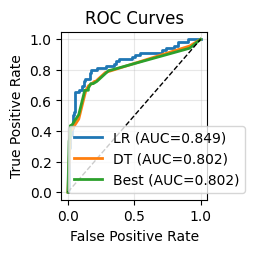

In [45]:
# ROC Curves
ax1 = plt.subplot(2, 3, 1)
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_test_proba)
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_test_proba)
fpr_best, tpr_best, _ = roc_curve(y_test, best_proba)

plt.plot(fpr_lr, tpr_lr, label=f'LR (AUC={lr_roc_auc:.3f})', linewidth=2)
plt.plot(fpr_dt, tpr_dt, label=f'DT (AUC={dt_roc_auc:.3f})', linewidth=2)
plt.plot(fpr_best, tpr_best, label=f'Best (AUC={best_roc:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True, alpha=0.3)

Text(0.5, 225.12222222222223, 'Predicted')

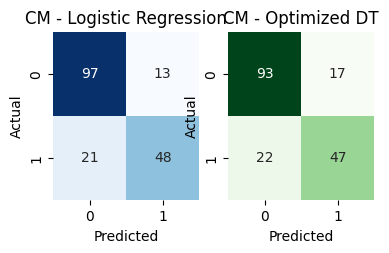

In [46]:
# Confusion Matrix - LR
ax2 = plt.subplot(2, 3, 2)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('CM - Logistic Regression')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Confusion Matrix - Best
ax3 = plt.subplot(2, 3, 3)
cm_best = confusion_matrix(y_test, best_pred)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('CM - Optimized DT')
plt.ylabel('Actual')
plt.xlabel('Predicted')

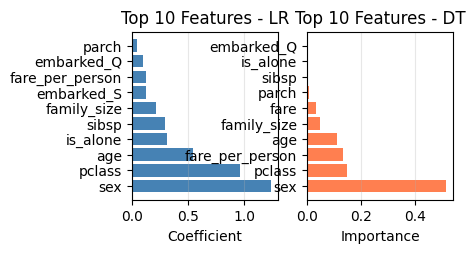

In [47]:
# Feature Importance - LR
ax4 = plt.subplot(2, 3, 4)
top10_lr = feat_imp_lr.head(10)
plt.barh(range(len(top10_lr)), top10_lr['Coefficient'].abs(), color='steelblue')
plt.yticks(range(len(top10_lr)), top10_lr['Feature'])
plt.xlabel('Coefficient')
plt.title('Top 10 Features - LR')
plt.grid(True, alpha=0.3, axis='x')

# Feature Importance - DT
ax5 = plt.subplot(2, 3, 5)
top10_dt = feat_imp_dt.head(10)
plt.barh(range(len(top10_dt)), top10_dt['Importance'], color='coral')
plt.yticks(range(len(top10_dt)), top10_dt['Feature'])
plt.xlabel('Importance')
plt.title('Top 10 Features - DT')
plt.grid(True, alpha=0.3, axis='x')


Visualization saved: task3_results.png


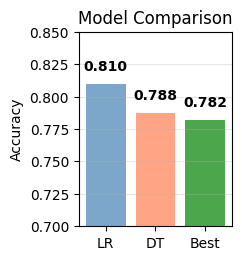

In [48]:
# Accuracy Comparison
ax6 = plt.subplot(2, 3, 6)
models = ['LR', 'DT', 'Best']
accs = results['Test_Acc'].values
colors = ['steelblue', 'coral', 'green']
bars = plt.bar(models, accs, color=colors, alpha=0.7)
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.ylim([0.7, 0.85])
for bar, val in zip(bars, accs):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.01,
             f'{val:.3f}', ha='center', fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('task3_results.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved: task3_results.png")
plt.show()

In [49]:
print("\n" + "="*80)
print("STEP 7: EXAMPLE PREDICTION")
print("-"*80)

idx = 5
sample = X_test.iloc[idx:idx+1]

print(f"\nSample passenger:")
print(f"  Class: {int(sample['pclass'].values[0])}")
print(f"  Sex: {'Male' if sample['sex'].values[0]==1 else 'Female'}")
print(f"  Age: {sample['age'].values[0]:.1f}")
print(f"  Fare: ${sample['fare'].values[0]:.2f}")

actual = "Survived" if y_test.iloc[idx] == 1 else "Not Survived"
print(f"\nActual: {actual}")

sample_scaled = scaler.transform(sample)

lr_p = lr_model.predict(sample_scaled)[0]
lr_prob = lr_model.predict_proba(sample_scaled)[0]
print(f"\nLR: {'Survived' if lr_p==1 else 'Not Survived'} ({max(lr_prob):.2%})")

dt_p = dt_model.predict(sample)[0]
dt_prob = dt_model.predict_proba(sample)[0]
print(f"DT: {'Survived' if dt_p==1 else 'Not Survived'} ({max(dt_prob):.2%})")

best_p = best_model.predict(sample)[0]
best_prob = best_model.predict_proba(sample)[0]
print(f"Best: {'Survived' if best_p==1 else 'Not Survived'} ({max(best_prob):.2%})")



STEP 7: EXAMPLE PREDICTION
--------------------------------------------------------------------------------

Sample passenger:
  Class: 3
  Sex: Female
  Age: 36.0
  Fare: $17.40

Actual: Survived

LR: Survived (51.15%)
DT: Not Survived (57.14%)
Best: Not Survived (57.14%)


In [50]:
print("\n" + "="*80)
print("TASK 3 COMPLETED SUCCESSFULLY")
print("="*80)

print(f"""
SUMMARY:
- Data preprocessed: {len(df_clean)} samples, {len(feature_cols)} features
- Logistic Regression: {lr_test_acc:.2%} accuracy
- Decision Tree: {dt_test_acc:.2%} accuracy
- Optimized DT: {best_acc:.2%} accuracy
- Best Model: {results.loc[best_idx, 'Model']}
""")

print("="*80)


TASK 3 COMPLETED SUCCESSFULLY

SUMMARY:
- Data preprocessed: 891 samples, 11 features
- Logistic Regression: 81.01% accuracy
- Decision Tree: 78.77% accuracy
- Optimized DT: 78.21% accuracy
- Best Model: Logistic Regression

